In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import glob
from keras.preprocessing.image import load_img


In [2]:
DIM=256
train_path = 'training/'

In [3]:
# images_path= 'image_2/'
# labels_path = 'semantic_rgb/'

# image_path = os.path.join(train_path,images_path)
# mask_path = os.path.join(train_path, labels_path)
# image_list = os.listdir(image_path)
# mask_list = os.listdir(mask_path)
# image_list = sorted([image_path+i for i in image_list])
# mask_list = sorted([mask_path+i for i in mask_list])

In [4]:
def load_raw_kitti(data_type='train', enc='ohe', shape='normal',dim=256):
  img_path = str(train_path) + '/' + data_type +'/images/'
  labels_path = str(train_path) + '/' + data_type + '/labels/'
  
  
  # without adding target_size=(dim,dim) in load_img we get Out of mem: 421x960x720x32x4bytes is around 34GB!
  x = np.array([np.array(load_img(str(img_path) + file, target_size=(dim,dim) ))*1./255 for file in sorted(os.listdir(img_path))])
  if(enc=='ohe'):
    y = np.array([np.array(load_img(str(labels_path) + file, target_size=(dim,dim))) for file in sorted(os.listdir(labels_path))])
  elif(enc=='sparse_cat'):
    y = np.array([np.array(load_img(str(labels_path) + file, target_size=(dim,dim))) for file in sorted(os.listdir(labels_path))])
  if(shape == 'flat'):
    y = np.reshape(y.shape[0], y.shape[1]*y.shape[2])
    y = np.expand_dims(y, axis=-1)
  return x, y

In [5]:
import time
start = time.time()
x_train, y_train = load_raw_kitti(data_type='train')
#x_test, y_test = load_raw_CAMVID(data_type='test')# Don't load test for RAM consumption
x_val, y_val = load_raw_kitti(data_type='valid')
end = time.time()
print('Time elapsed: ', end-start)

print(x_train.shape)
print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

Time elapsed:  3.125999689102173
(162, 256, 256, 3)
(162, 256, 256, 3)
(38, 256, 256, 3)
(38, 256, 256, 3)


In [6]:
# for i in range(len(y_val)):
#     fig , ax = plt.subplots(1,2)
#     rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(y_train[i], axis=-1), -1))
#     ax[0].imshow(rgb_mask,'BrBG')
#     original = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(y_val[i], axis=-1), -1))
#     ax[1].imshow(original)

In [7]:
classes = pd.read_csv('classes.csv',index_col='Unnamed: 0')
classes = classes[4:]
classes.head()
# len(classes)aa

,0,1,2
static,0,0,0
dynamic,111,74,0
ground,81,0,81
road,128,64,128
sidewalk,244,35,232


In [8]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
def adjust_mask(mask, flat=False):
    
    semantic_map = []
    for colour in list(cls2rgb.values()): 
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
      semantic_map = np.reshape(semantic_map, (-1,128*128))

    return np.float16(semantic_map)# convert to numbers


In [9]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
def map_class_to_rgb(p): 
  return idx2rgb[p[0]]

In [10]:
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

# model.compile(optimizer='sgd', loss=loss, metrics=[dice_coefficient])

In [11]:
# Data generator
batch_sz = 4
#https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rotation_range=0.1,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    #rescale=1./255)# Data is already scaled when loaded

mask_gen_args = dict(rotation_range=0.1,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    #preprocessing_function=adjust_mask)# This is not possible since the preprocessing_function can only return the same shape as image

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow(
    x_train,
    seed=seed,
    batch_size=batch_sz)

mask_generator = mask_datagen.flow( 
    y_train,
    seed=seed,
    batch_size=batch_sz)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)  
        
val_image_generator = image_datagen.flow(
    x_val,
    seed=seed,
    batch_size=batch_sz)

val_mask_generator = mask_datagen.flow(
    y_val,
    seed=seed,
    batch_size=batch_sz)

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)        
        
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)         


In [13]:
from model import Deeplabv3
deeplab_model = Deeplabv3(weights= 'cityscapes' , input_shape=(256, 256, 3), classes=31,activation='softmax')  

In [16]:
deeplab_model.compile(loss = jaccard_distance, optimizer='adam', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=31)])
batch_sz=4
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint('deeplabv3plus.hdf5', monitor='val_loss',verbose=1, save_best_only=True,)
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 15,
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000000001
)



deeplab_model.fit(train_generator_fn(), validation_data= val_generator_fn(),
                  steps_per_epoch=168 // batch_sz
                  , validation_steps=9,
                  epochs=200,callbacks=[model_checkpoint,reduce_lr])

Epoch 1/200
42/42 [==============================] - 24s 389ms/step - loss: 0.8496 - accuracy: 0.5499 - mean_io_u_1: 0.4839 - val_loss: 1.1199 - val_accuracy: 0.4010 - val_mean_io_u_1: 0.4989

Epoch 00001: val_loss improved from inf to 1.11994, saving model to deeplabv3plus.hdf5


C:\Users\20100\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
42/42 [==============================] - 14s 343ms/step - loss: 0.5925 - accuracy: 0.6499 - mean_io_u_1: 0.5020 - val_loss: 1.2872 - val_accuracy: 0.2971 - val_mean_io_u_1: 0.5041

Epoch 00002: val_loss did not improve from 1.11994
Epoch 3/200
42/42 [==============================] - 14s 340ms/step - loss: 0.5160 - accuracy: 0.6909 - mean_io_u_1: 0.5046 - val_loss: 1.2151 - val_accuracy: 0.3218 - val_mean_io_u_1: 0.5046

Epoch 00003: val_loss did not improve from 1.11994
Epoch 4/200
42/42 [==============================] - 14s 344ms/step - loss: 0.4774 - accuracy: 0.7100 - mean_io_u_1: 0.5044 - val_loss: 0.9512 - val_accuracy: 0.4850 - val_mean_io_u_1: 0.5065

Epoch 00004: val_loss improved from 1.11994 to 0.95116, saving model to deeplabv3plus.hdf5
Epoch 5/200
42/42 [==============================] - 16s 381ms/step - loss: 0.4651 - accuracy: 0.7135 - mean_io_u_1: 0.5079 - val_loss: 0.8289 - val_accuracy: 0.5333 - val_mean_io_u_1: 0.5099

Epoch 00005: val_loss improved from

KeyboardInterrupt: 

In [19]:
from keras.models import load_model
best_model = load_model("deeplabv3plus.hdf5", custom_objects={"jaccard_distance":jaccard_distance})

best_model.evaluate(val_generator_fn())

ValueError: Cannot assign to variable total_confusion_matrix:0 due to variable shape (31, 31) and value shape () are incompatible

In [20]:
preds = best_model.predict(x_val)

<ipython-input-24-bc2daa94cf45>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots(1,2)


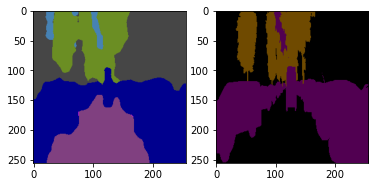

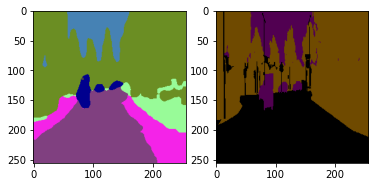

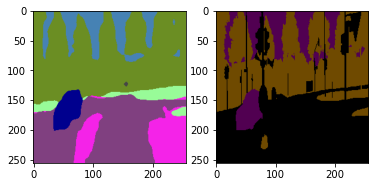

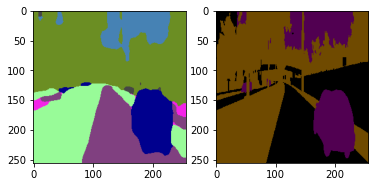

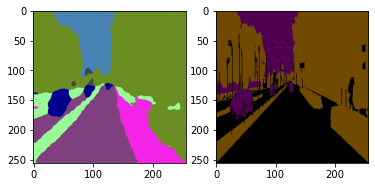

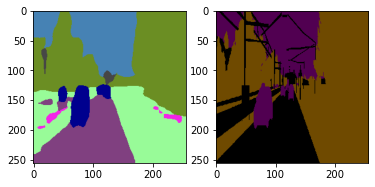

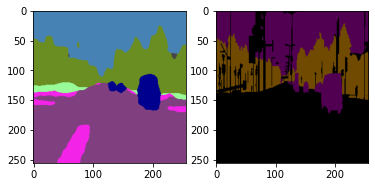

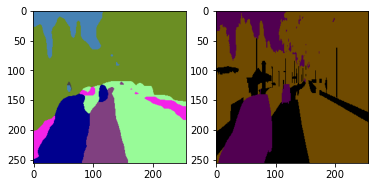

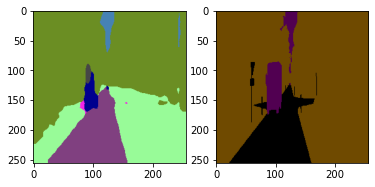

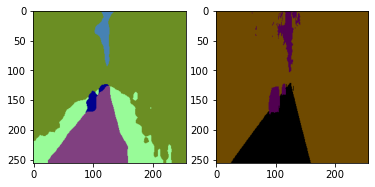

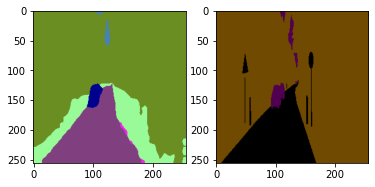

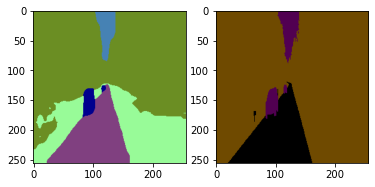

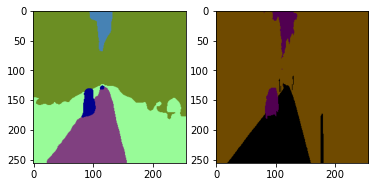

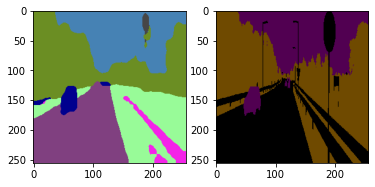

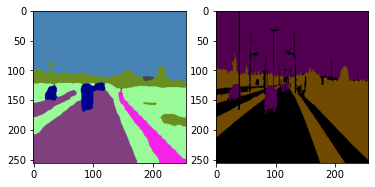

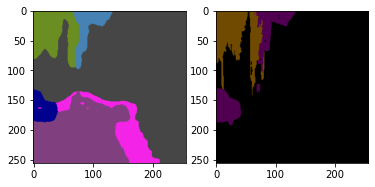

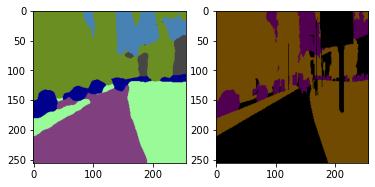

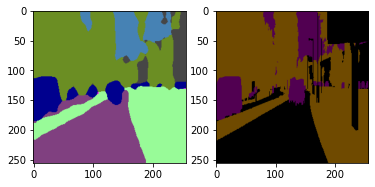

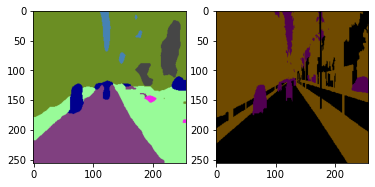

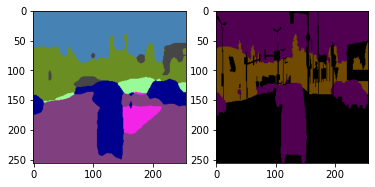

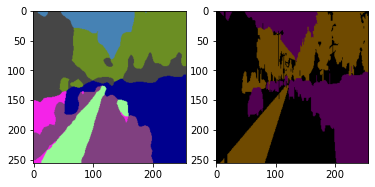

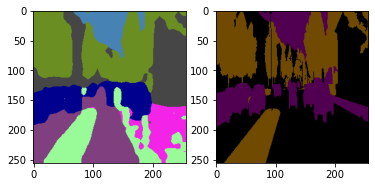

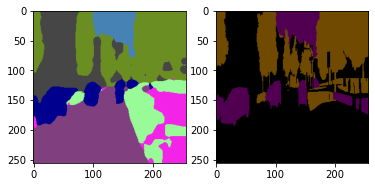

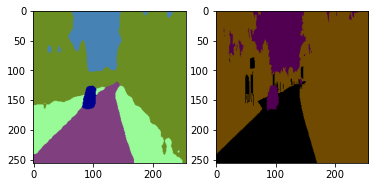

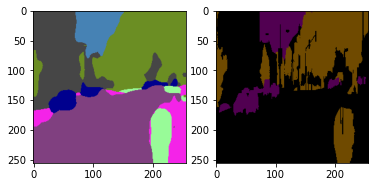

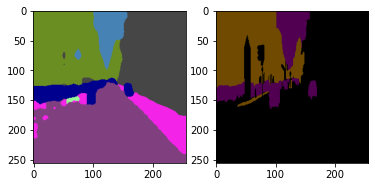

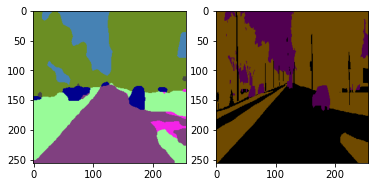

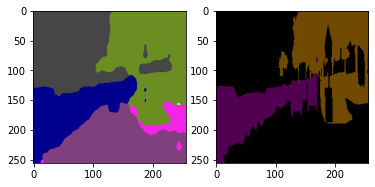

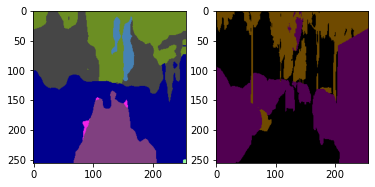

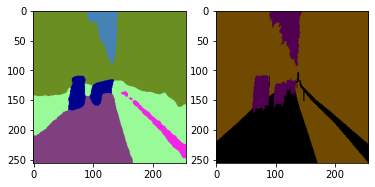

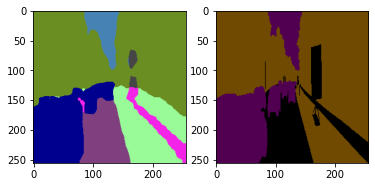

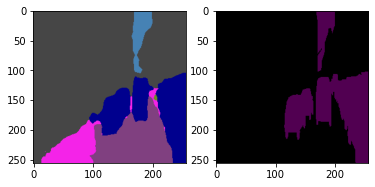

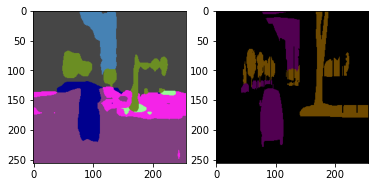

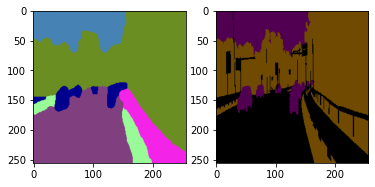

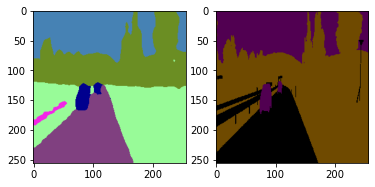

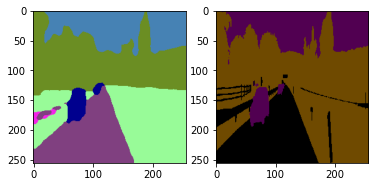

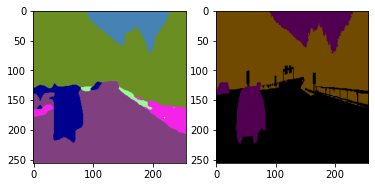

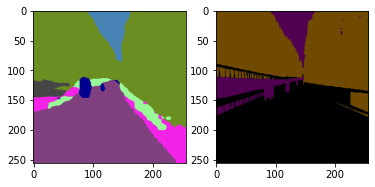

In [24]:
for i in range(len(y_val)):
    fig , ax = plt.subplots(1,2)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(preds[i], axis=-1), -1))
    ax[0].imshow(rgb_mask)
    original = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(y_val[i]/(255.), axis=-1), -1))
    ax[1].imshow(original)

In [27]:
y_val[0].shape, preds[0].shape

((256, 256, 3), (256, 256, 31))

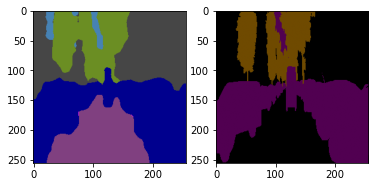

In [31]:
fig , ax = plt.subplots(1,2)

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(preds[0], axis=-1), -1))
ax[0].imshow(rgb_mask)
original = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(y_val[0], axis=-1), -1))
ax[1].imshow(original/255.)


In [33]:
original,  rgb_mask

(array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [81,  0, 81],
         [81,  0, 81],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [81,  0, 81],
         [81,  0, 81],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [81,  0, 81],
         [81,  0, 81],
         [ 0,  0,  0]]]),
 array([[[ 70,  70,  70],
         [ 70,  70,  70],
   